In [1]:
import torch
import torch.nn.functional as F
from models import Create_nets
from datasets import get_dataloader
#from options import TrainOptions
from torchvision import models
import os
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import cv2
from utils.results import *
from matplotlib.cm import viridis
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from utils.dataloader import get_paths_mvtec
from datasets import ImageDataset_mvtec
from torch.utils.data import DataLoader
import copy

In [2]:
import os
import json

class TrainOptions:
    def __init__(self):
        self.exp_name = "DEV_USDR"
        self.epoch_start = 0
        self.epoch_num = 1
        self.factor = 1
        self.seed = 233
        self.fixed_seed_bool = True
        self.test_seed = 400
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/mvtec_anomaly_detection/'
        self.data_category = "screw"
        self.data_set = "mvtec"
        self.batch_size = 2
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.results_dir = 'results'
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.contamination_rate = 0.1
        self.assumed_contamination_rate = 0.1
        self.mode = 'mvtec'
        self.development = False
        self.parser = None
        self.initialized = False


In [3]:
args = TrainOptions()
os.makedirs(args.results_dir, exist_ok=True)
os.makedirs(os.path.join(args.results_dir, args.data_set, f'contamination_{int(args.contamination_rate*100)}', f'{args.exp_name}-{args.data_category}', args.image_result_dir), exist_ok=True)
os.makedirs(os.path.join(args.results_dir, args.data_set, f'contamination_{int(args.contamination_rate*100)}', f'{args.exp_name}-{args.data_category}', args.model_result_dir), exist_ok=True)

try:
    with open(os.path.join('configurations', f'{args.data_set}.json'), 'r') as file:
        dataset_parameters = json.load(file)
    setattr(args, 'dataset_parameters', dataset_parameters)
except FileNotFoundError:
    print(f"Configuration file for {args.data_set} not found. Proceeding with default parameters.")
    setattr(args, 'dataset_parameters', {})
    
torch.manual_seed(args.seed)


np.random.seed(args.seed)
torch.cuda.manual_seed(args.seed)

## USDR

In [26]:
anomaly_categories={
    "bottle": ["broken_large", "broken_small", "contamination"],
    "cable": ["bent_wire", "cable_swap", "combined", "cut_inner_insulation", "cut_outer_insulation", "missing_cable", "missing_wire", "poke_insulation"],
    "capsule": ["crack", "faulty_imprint", "poke", "scratch","squeeze"],
    "carpet": ["color", "cut", "hole", "metal_contamination", "thread"],
    "grid": ["bent", "broken", "glue", "metal_contamination", "thread"],
    "hazelnut": ["crack", "cut", "hole", "print"],
    "leather": ["color", "cut", "fold", "glue", "poke"],
    "metal_nut": ["bent", "color", "flip", "scratch"],
    "pill": ["color", "combined","contamination", "crack", "faulty_imprint", "pill_type","scratch"],
    "screw": ["manipulated_front", "scratch_head", "scratch_neck","thread_side", "thread_top"],
    "tile": ["crack", "glue_strip", "gray_stroke", "oil","rough"],
    "toothbrush": ["defective"],
    "transistor": ["bent_lead", "cut_lead", "damaged_case", "misplaced"],
    "wood": ["color", "combined", "hole", "liquid", "scratch"],
    "zipper": ["broken_teeth", "combined","fabric_border", "fabric_interior","split_teeth","rough", "squeezed_teeth"]
    }
category='screw'
anocat=anomaly_categories[category]

In [5]:
normal_images, validation_images, sampled_anomalies_for_train, sampled_anomalies_for_val, good_images_test, remaining_anomalies_test = get_paths_mvtec(args,verbose=True)
DATA_PATH=os.path.join(args.data_root,args.data_category)
# combine good and anomalies
train_data=normal_images+sampled_anomalies_for_train
labels_train=[0]*len(normal_images)+[1]*len(sampled_anomalies_for_train)

category: screw, normals train:  320, anomalies test: 119, normal test: 41
anomalies test total:     {'manipulated_front': 24, 'scratch_head': 24, 'scratch_neck': 25, 'thread_side': 23, 'thread_top': 23}
anomalies test sampled:   {'manipulated_front': 6, 'scratch_head': 6, 'scratch_neck': 6, 'thread_side': 6, 'thread_top': 6}
anomalies test remaining: {'manipulated_front': 18, 'scratch_head': 18, 'scratch_neck': 19, 'thread_side': 17, 'thread_top': 17}


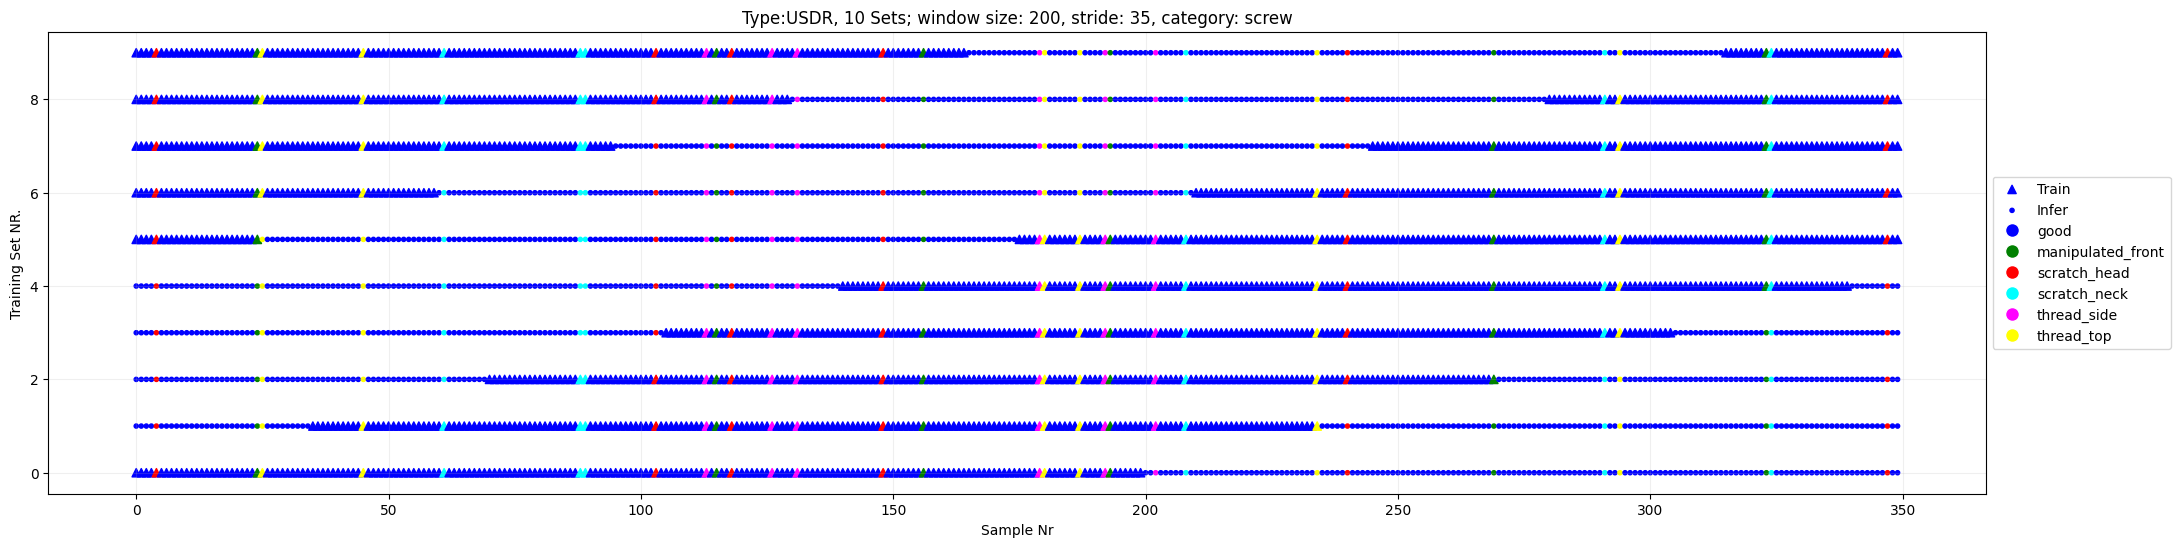

In [6]:
np.random.seed(args.seed)
N_samples = len(train_data)
idx = np.arange(N_samples)
np.random.shuffle(idx)

all_data_paths=[train_data[id]for id in idx]
ano_cols = [ 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'white']
colorvec=['blue']*len(train_data)#all cols to blue base is normal

anocat=args.dataset_parameters['anomaly_categories'][args.data_category]

for i,cat in enumerate(anocat):
    for id_, (col,path) in enumerate(zip(colorvec,all_data_paths)):
        if cat in path:
            colorvec[id_]=ano_cols[i]


# VISUALIZATION WITH 2 HISTOGRAMS PER SPLIT (TRAIN, TEST) NORMAL/ABNORMAL IN SPLIT OUT OF SPLIT
##USDR
stride = 35
window_size = 200
# Create train sets
shifts = np.floor(N_samples / stride)
train_sets = int(shifts)

train_ind_ls = []
for i in range(train_sets):
    train_ind_ls.append(idx[np.arange(i * stride, i * stride + window_size) % N_samples])
#save split plot  
plot_splits(train_ind_ls, idx, all_data_paths, train_sets, anocat, args.data_category, stride, window_size,splittype='USDR',EXPERIMENT_PATH=None)

In [11]:
import pickle
file_path = "/home/bule/projects/UTRAD/results/mvtec/contamination_10/USDR_27_05_24_8set-screw/all_train_paths_j.pkl"
with open(file_path, "rb") as file:
    data = pickle.load(file)
    
file_path = "/home/bule/projects/UTRAD/results/mvtec/contamination_10/USDR_27_05_24_8set-screw/allscores_utrad.pkl"
with open(file_path, "rb") as file:
    scores = pickle.load(file)
    
file_path = '/home/bule/projects/UTRAD/results/mvtec/contamination_10/USDR_27_05_24_8set-screw/experiment_paths.json'
with open(file_path, 'r') as file:
    experimentpaths = json.load(file)

df = pd.read_pickle('/home/bule/projects/UTRAD/results/mvtec/contamination_10/USDR_27_05_24_8set-screw/USDR_window:182_stride:42.pkl')

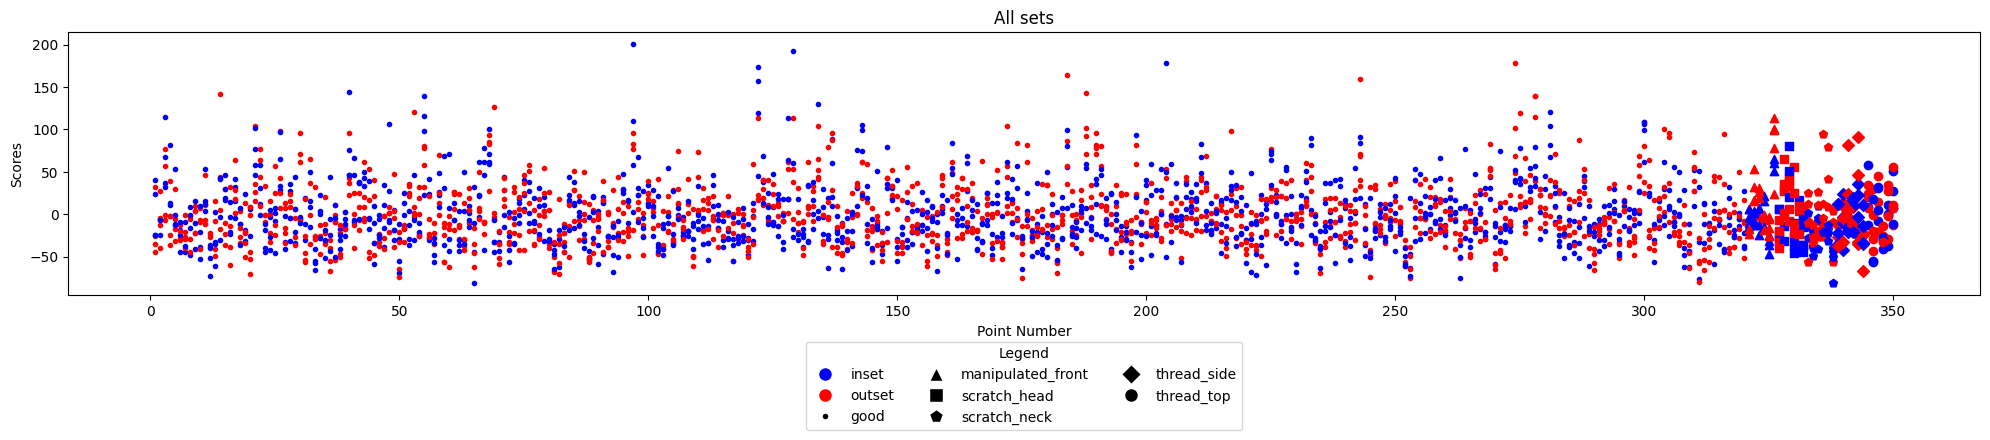

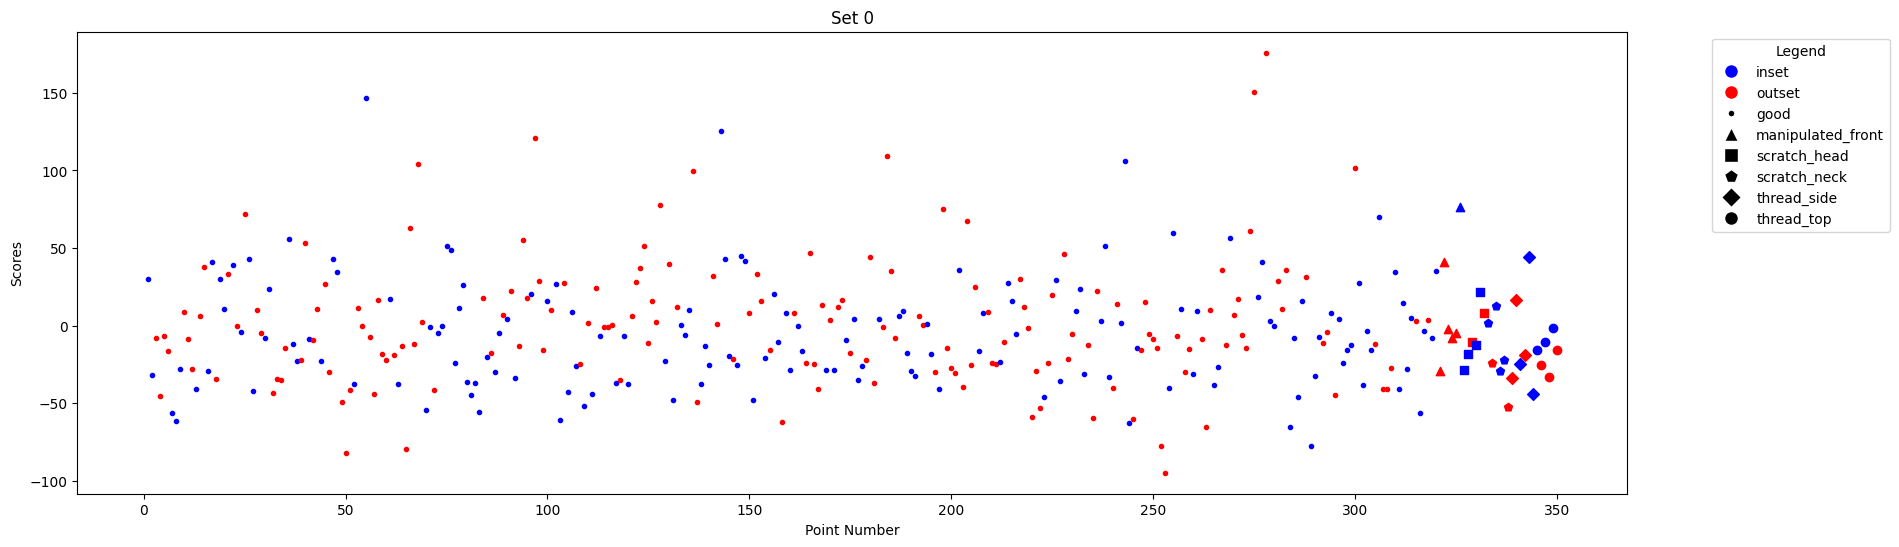

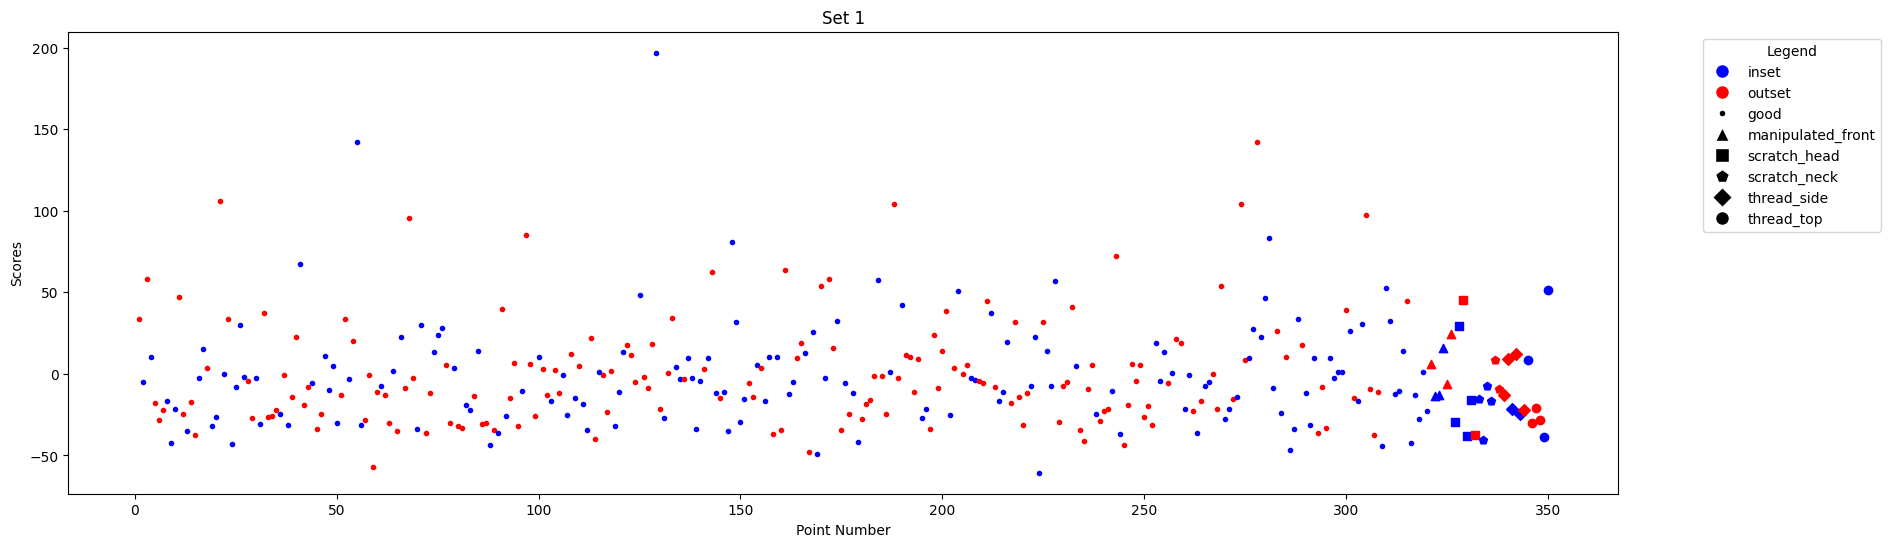

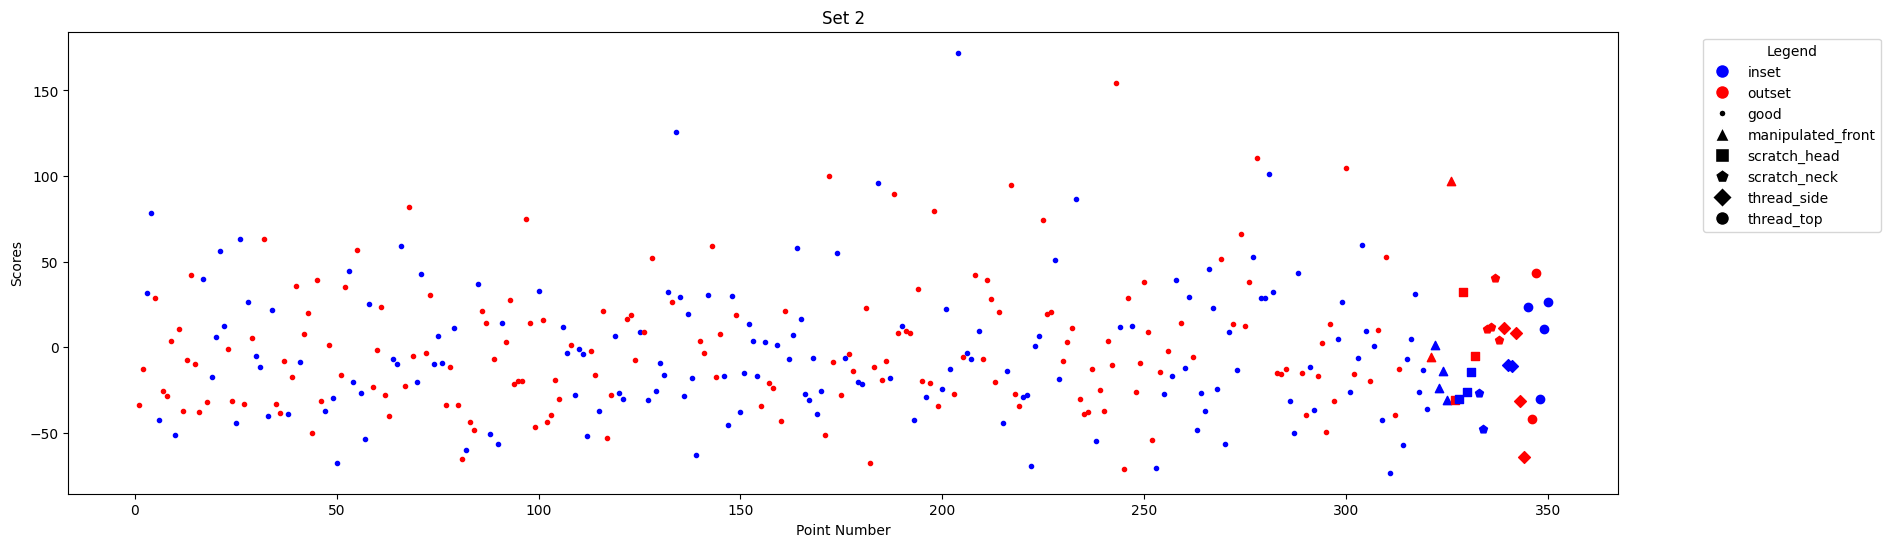

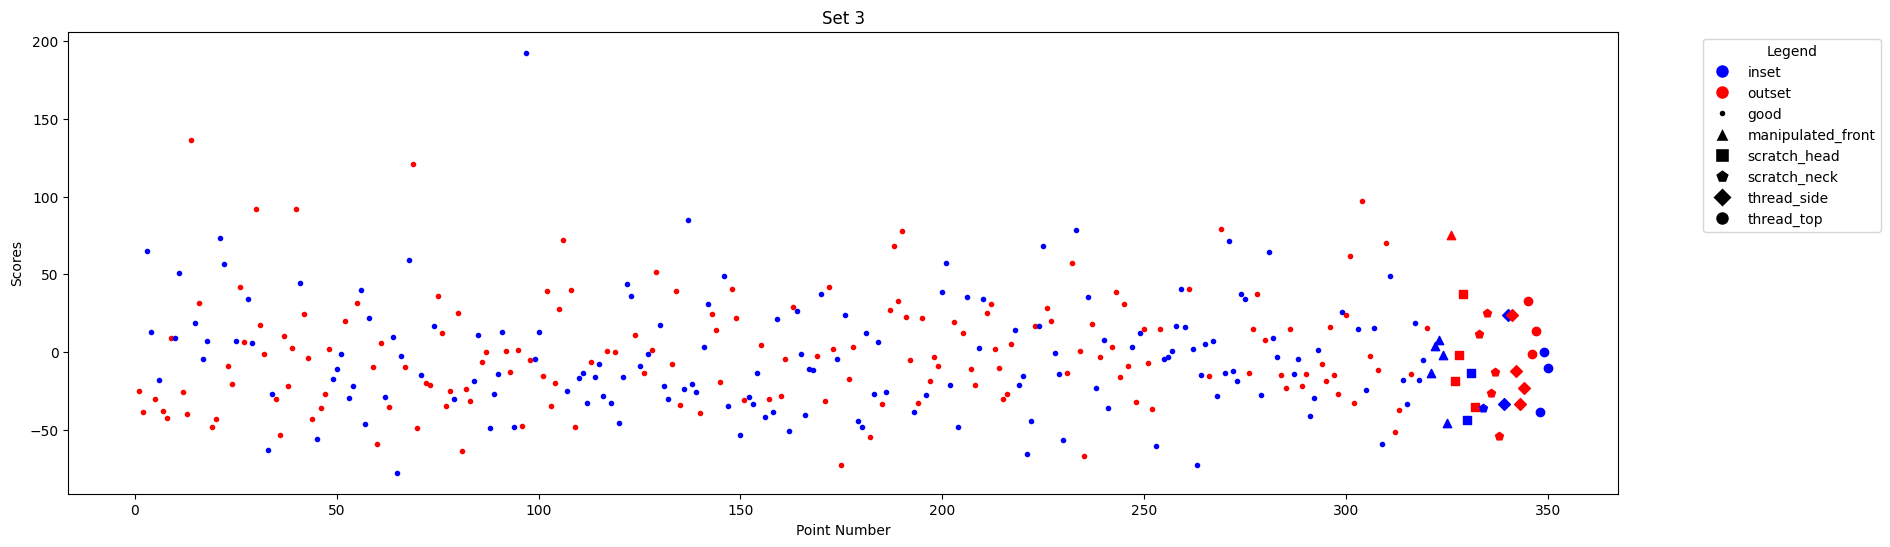

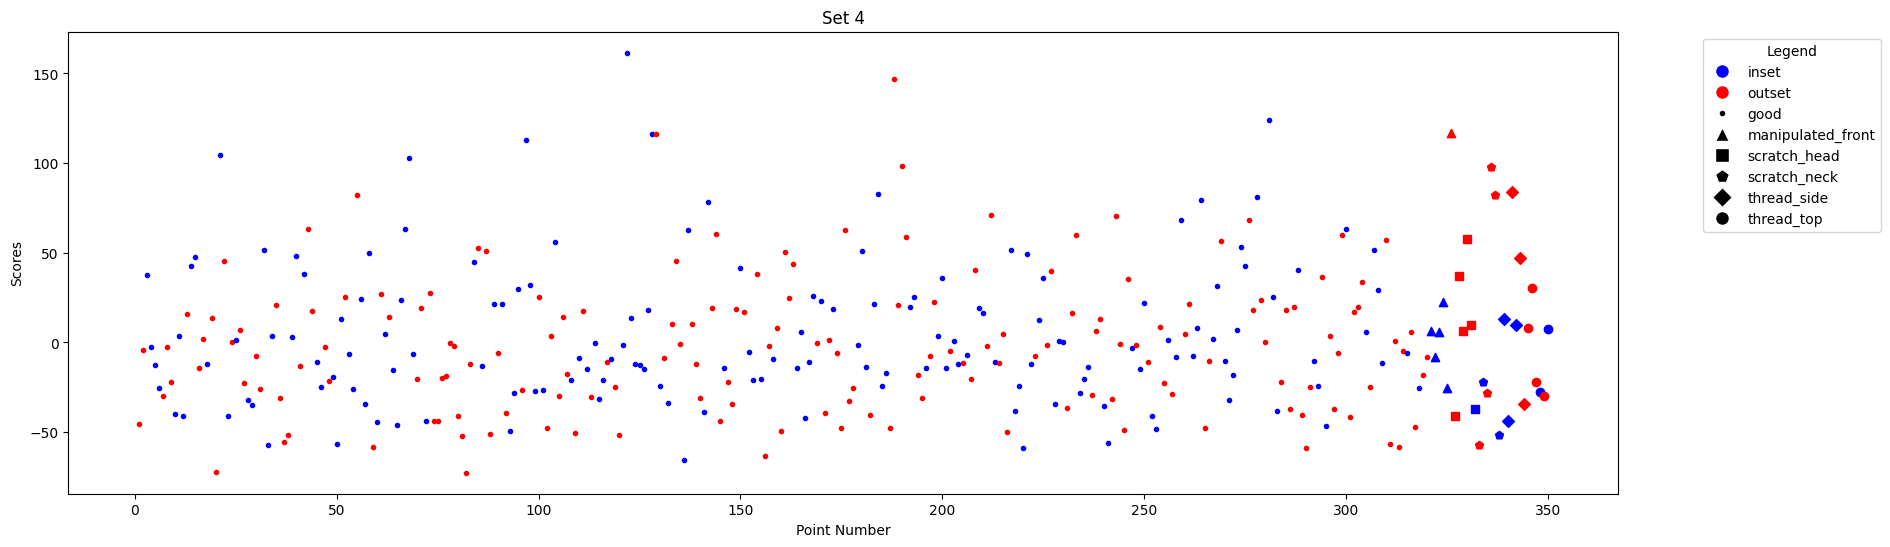

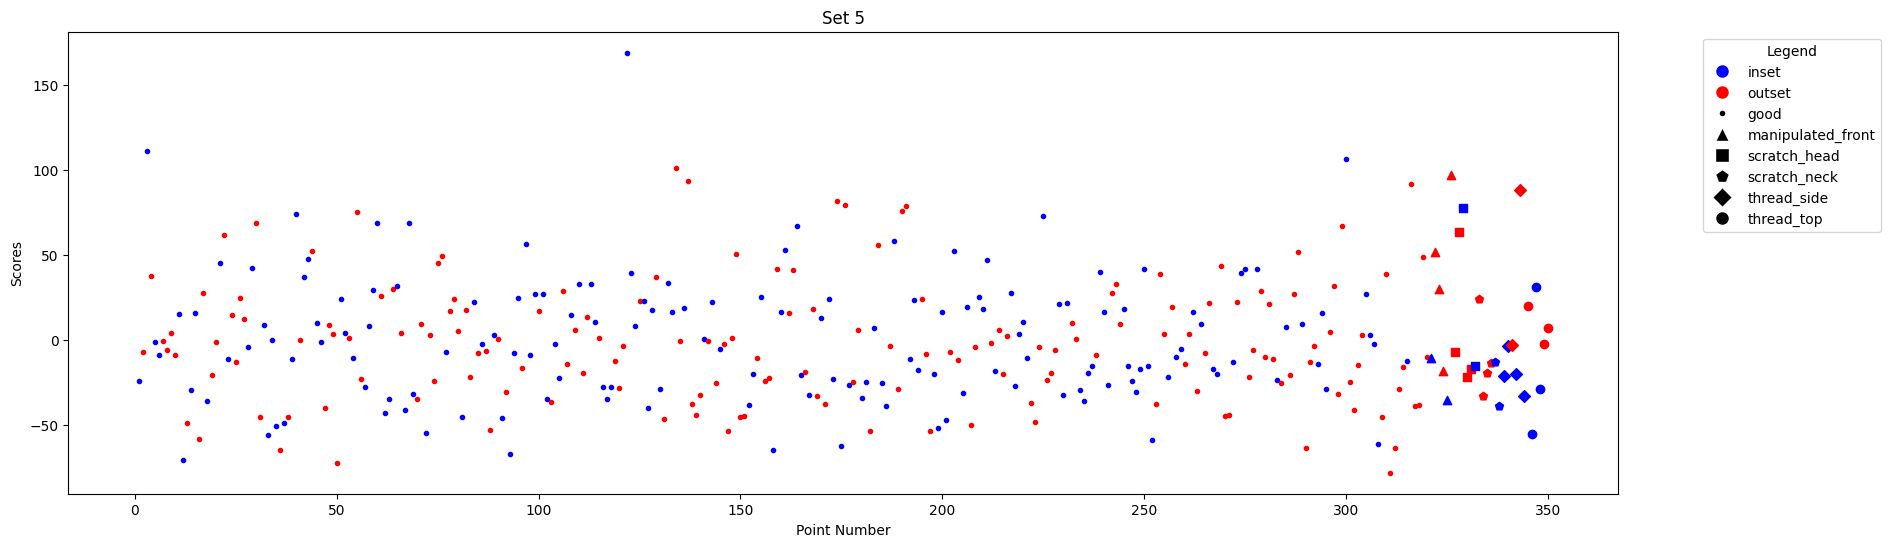

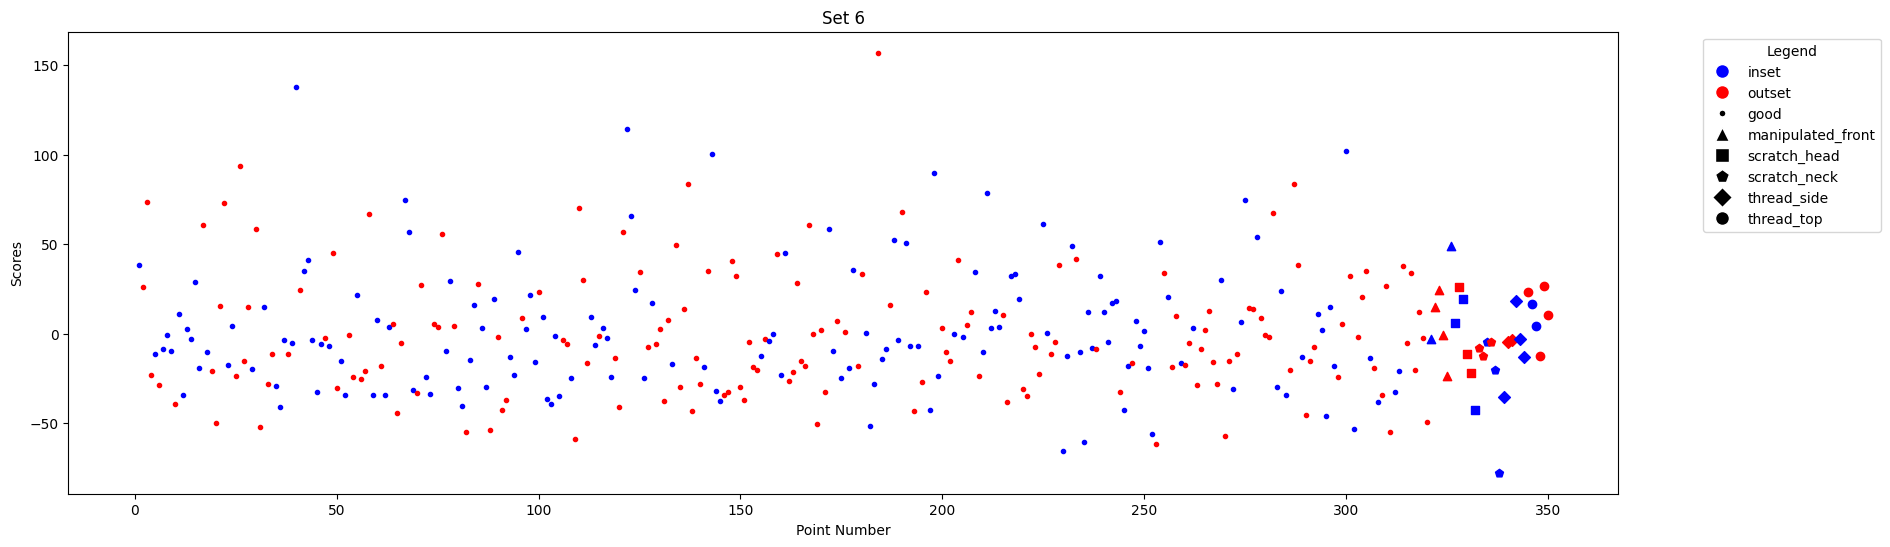

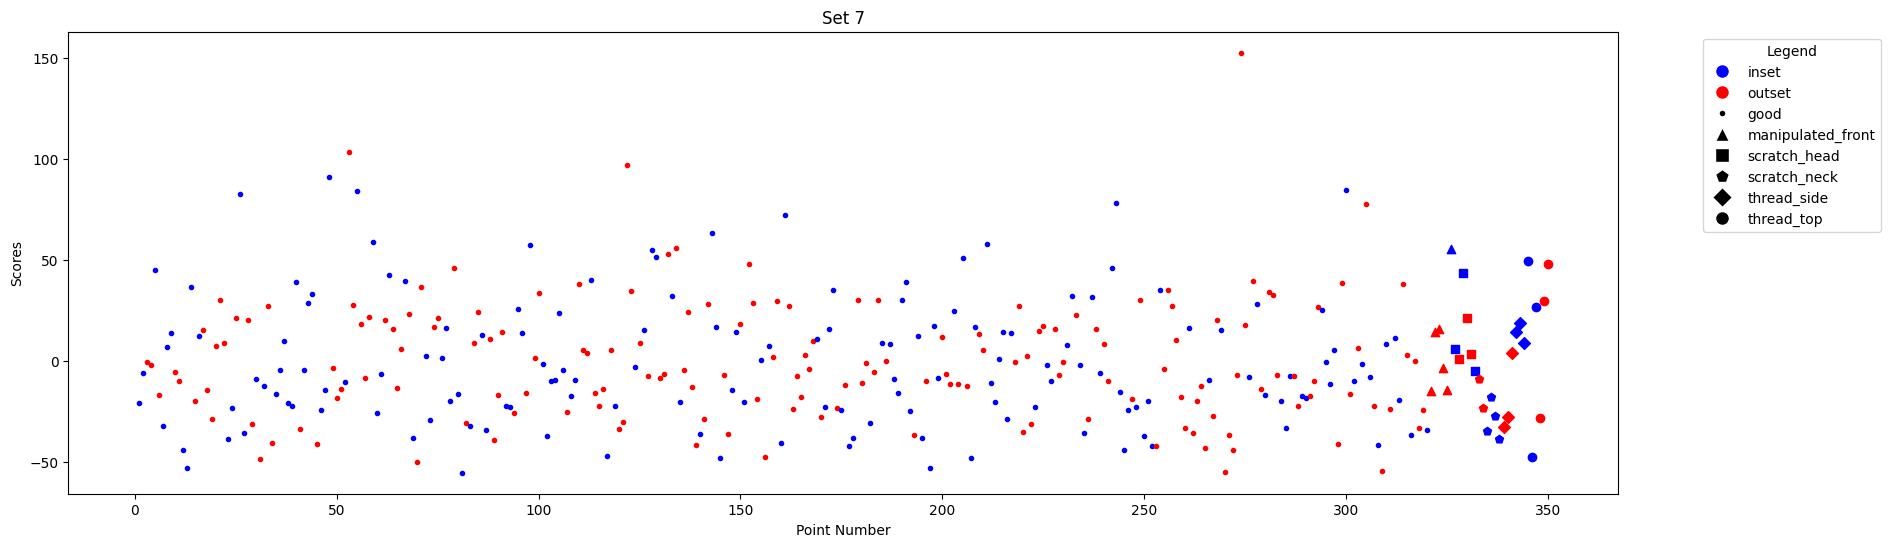

In [12]:
set_j=0
cats=['good']+anocat

orig_paths=experimentpaths['train']

idx = np.arange(len(orig_paths))
np.random.shuffle(idx)


orig_paths=[orig_paths[id]for id in idx]



# indicator for anomaly
ano_ind=[0]*len(orig_paths)
for n,cat in enumerate(cats):
    for i in range(len(ano_ind)):
        if cat in orig_paths[i]:
            ano_ind[i]=n


inset_tot={i:[] for i in np.arange(scores.shape[1])}
outset_tot={i:[] for i in np.arange(scores.shape[1])}

################################# ALLSETS togehter
plt.figure(figsize=(20, 6))
for set_j in range(scores.shape[0]):
    # indicator inset or not
    inset_ind=[1 if ptf in data[set_j] else 0 for ptf in orig_paths]
    scores_j=scores[set_j]
    
    combined = list(zip(scores_j, ano_ind, inset_ind))
    sorted_combined = sorted(combined, key=lambda x: x[1])
    sorted_scores_j, sorted_ano_ind, sorted_inset_ind = zip(*sorted_combined)
    sorted_scores_j=(np.array(sorted_scores_j)-np.mean([sorted_scores_j[i] for i in range(len(sorted_scores_j)) if sorted_inset_ind[i]==1]))/np.var([sorted_scores_j[i] for i in range(len(sorted_scores_j)) if sorted_inset_ind[i]==1])

    ## create difference dataset:
    
    for n,comm in enumerate(zip(scores_j,inset_ind)):
        if comm[1]==1:
            inset_tot[n].append(comm[0])
        else:
            outset_tot[n].append(comm[0])
    
    
    # Create a bar plot
    # plt.figure(figsize=(20, 6))
    colors = ['blue' if 0 == sorted_inset_ind[x] else 'red' for x in range(len(sorted_scores_j))] 
    markers_list = ['.', '^', 's', 'p', 'D','o'] 
    color_labels = {'blue': 'inset', 'red': 'outset'}

    markers=[markers_list[x] for x in sorted_ano_ind]
    x_values = list(range(1, len(sorted_scores_j) + 1))

    # Create a scatter plot
    for i in range(len(sorted_scores_j)):
        plt.scatter(x_values[i], sorted_scores_j[i], color=colors[i], marker=markers[i])

    # Add title and labels
    # Add legend for colors and markers
    legend_elements = []
    for color in color_labels:
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=color_labels[color]))

    for i, marker in enumerate(markers_list):
        legend_elements.append(plt.Line2D([0], [0], marker=marker, color='w', markerfacecolor='k', markersize=10, label=cats[i]))

plt.title(f'All sets')
plt.xlabel('Point Number')
plt.ylabel('Scores')
# Add legend below the plot
plt.legend(handles=legend_elements, title="Legend", loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0.1, 1, 0.9])
plt.show()


##################################################### Individual Sets

for set_j in range(scores.shape[0]):
    plt.figure(figsize=(20, 6))
    # indicator inset or not
    inset_ind=[1 if ptf in data[set_j] else 0 for ptf in orig_paths]
    scores_j=scores[set_j]
    
    combined = list(zip(scores_j, ano_ind, inset_ind))
    sorted_combined = sorted(combined, key=lambda x: x[1])
    sorted_scores_j, sorted_ano_ind, sorted_inset_ind = zip(*sorted_combined)
    
    sorted_scores_j=(np.array(sorted_scores_j)-np.mean([sorted_scores_j[i] for i in range(len(sorted_scores_j)) if sorted_inset_ind[i]==1]))/np.var([sorted_scores_j[i] for i in range(len(sorted_scores_j)) if sorted_inset_ind[i]==0])

    ## create difference dataset:
    
    for n,comm in enumerate(zip(scores_j,inset_ind)):
        if comm[1]==1:
            inset_tot[n].append(comm[0])
        else:
            outset_tot[n].append(comm[0])
    
    
    # Create a bar plot
    # plt.figure(figsize=(20, 6))
    colors = ['blue' if 0 == sorted_inset_ind[x] else 'red' for x in range(len(sorted_scores_j))] 
    markers_list = ['.', '^', 's', 'p', 'D','o'] 
    color_labels = {'blue': 'inset', 'red': 'outset'}

    markers=[markers_list[x] for x in sorted_ano_ind]
    x_values = list(range(1, len(sorted_scores_j) + 1))

    # Create a scatter plot
    for i in range(len(sorted_scores_j)):
        plt.scatter(x_values[i], sorted_scores_j[i], color=colors[i], marker=markers[i])

    # Add title and labels
    # Add legend for colors and markers
    legend_elements = []
    for color in color_labels:
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=color_labels[color]))

    for i, marker in enumerate(markers_list):
        legend_elements.append(plt.Line2D([0], [0], marker=marker, color='w', markerfacecolor='k', markersize=10, label=cats[i]))

    plt.title(f'Set {set_j}')
    plt.xlabel('Point Number')
    plt.ylabel('Scores')
    plt.legend(handles=legend_elements, title="Legend", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

### difference between means of each datapooint

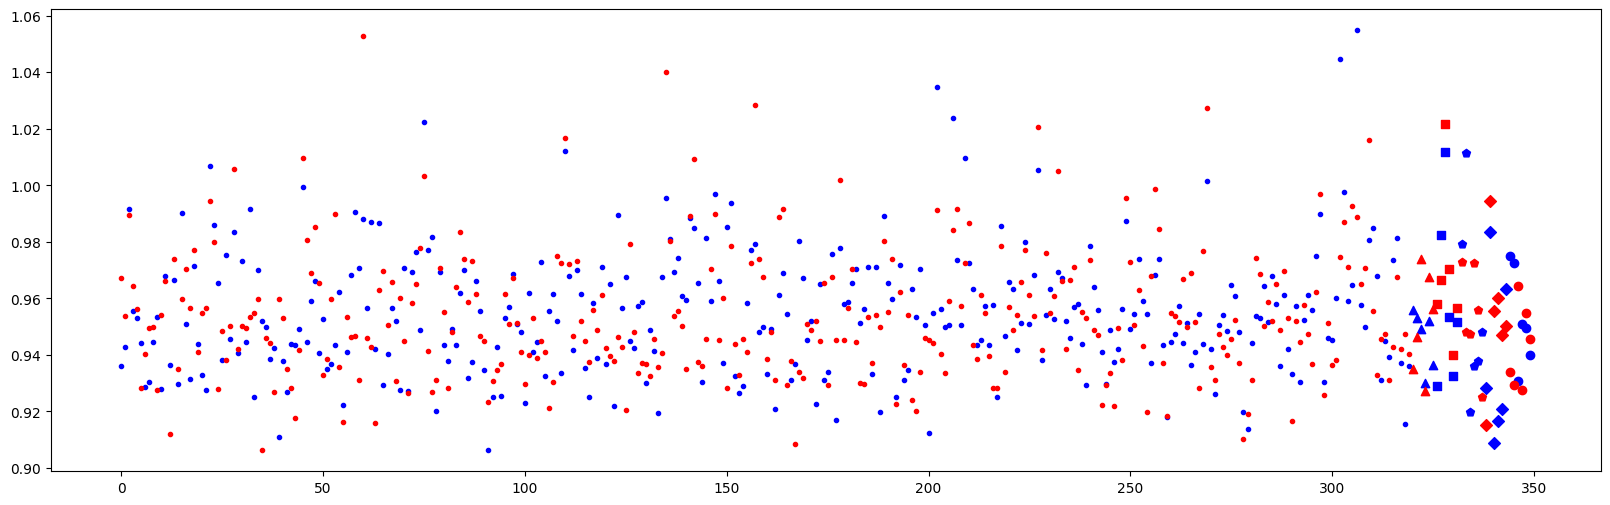

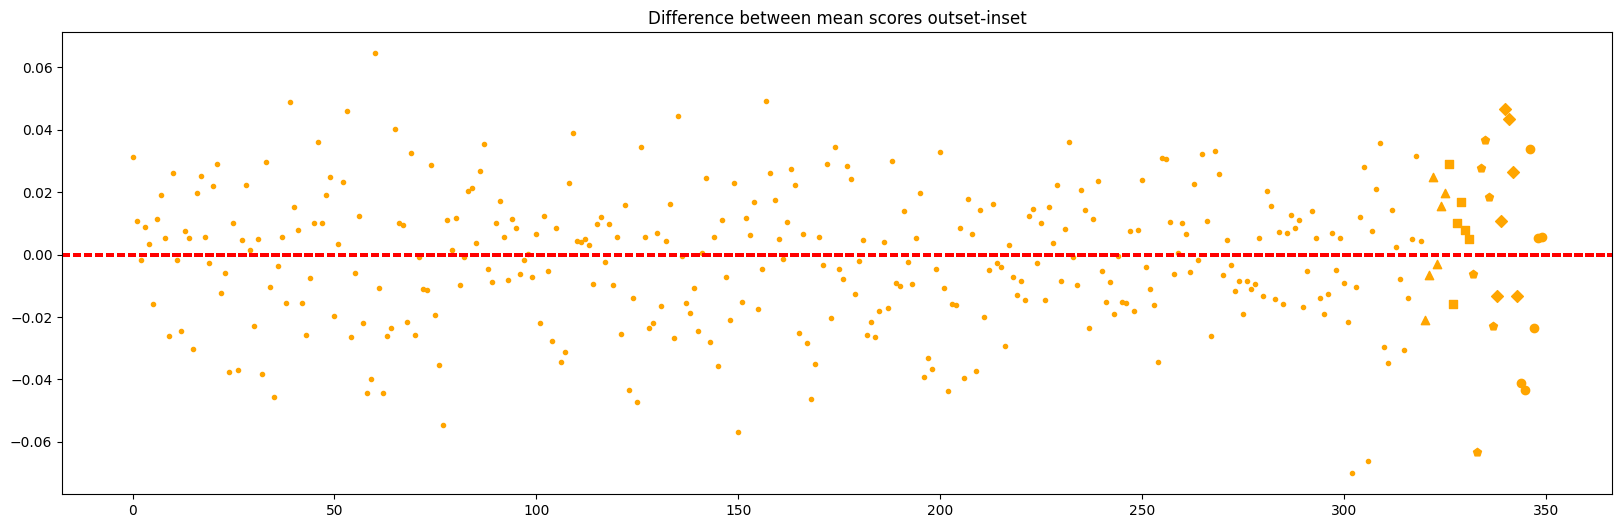

In [13]:
inset_tot_means={i:np.mean(inset_tot[i]) for i in inset_tot.keys()}
outset_tot_means={i:np.mean(outset_tot[i]) for i in outset_tot.keys()}

length=len(list(inset_tot_means.values()))
colors=['blue']*length
plt.figure(figsize=(20, 6))
for i in range(length):
    plt.scatter(list(np.arange(length))[i], list(inset_tot_means.values())[i],c=colors[i], marker=markers[i])
    
length=len(list(outset_tot_means.values()))
colors=['red']*length
    
for i in range(length):
    plt.scatter(list(np.arange(length))[i], list(outset_tot_means.values())[i],c=colors[i], marker=markers[i])
    
plt.show() 
    
plt.figure(figsize=(20, 6))
colors=['orange']*length

difference=np.array(list(outset_tot_means.values()))-np.array(list(inset_tot_means.values()))

for i in range(length):
    plt.scatter(list(np.arange(length))[i],difference[i],c=colors[i], marker=markers[i])
    plt.axhline(y=0, color='red', linestyle='--')
plt.title('Difference between mean scores outset-inset')
plt.show()

### Difference between medians of each datapoint

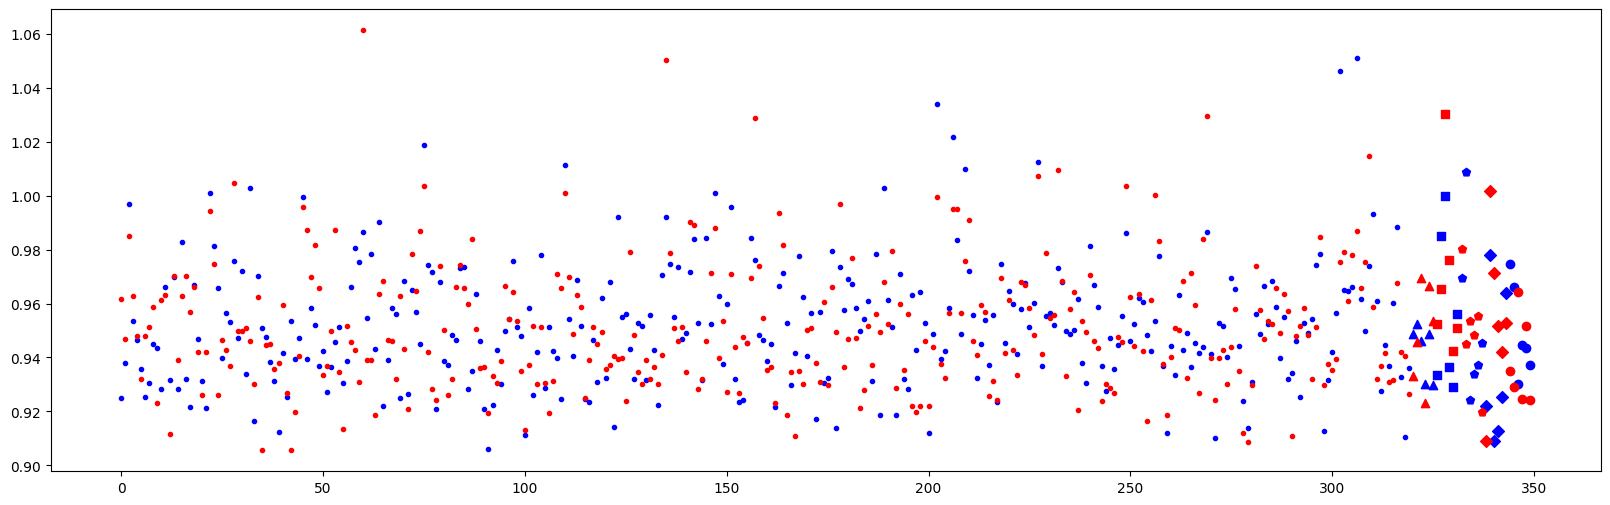

Text(0.5, 1.0, 'Difference between median scores outset-inset')

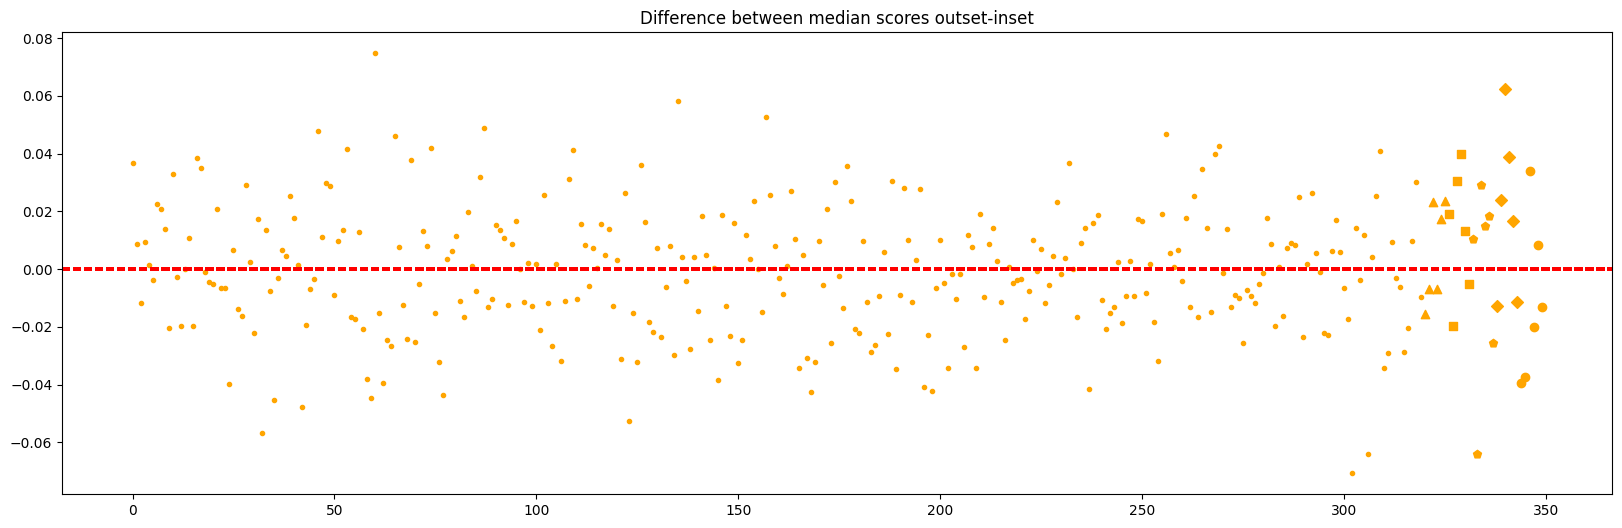

In [14]:
inset_tot_means={i:np.median(inset_tot[i]) for i in inset_tot.keys()}
outset_tot_means={i:np.median(outset_tot[i]) for i in outset_tot.keys()}

length=len(list(inset_tot_means.values()))
colors=['blue']*length
plt.figure(figsize=(20, 6))
for i in range(length):
    plt.scatter(list(np.arange(length))[i], list(inset_tot_means.values())[i],c=colors[i], marker=markers[i])
    
length=len(list(outset_tot_means.values()))
colors=['red']*length
    
for i in range(length):
    plt.scatter(list(np.arange(length))[i], list(outset_tot_means.values())[i],c=colors[i], marker=markers[i])
    
plt.show() 
    
plt.figure(figsize=(20, 6))
colors=['orange']*length

difference=np.array(list(outset_tot_means.values()))-np.array(list(inset_tot_means.values()))

for i in range(length):
    plt.scatter(list(np.arange(length))[i],difference[i],c=colors[i], marker=markers[i])
    plt.axhline(y=0, color='red', linestyle='--')
plt.title('Difference between median scores outset-inset')

### Difference between vars of each datapoint

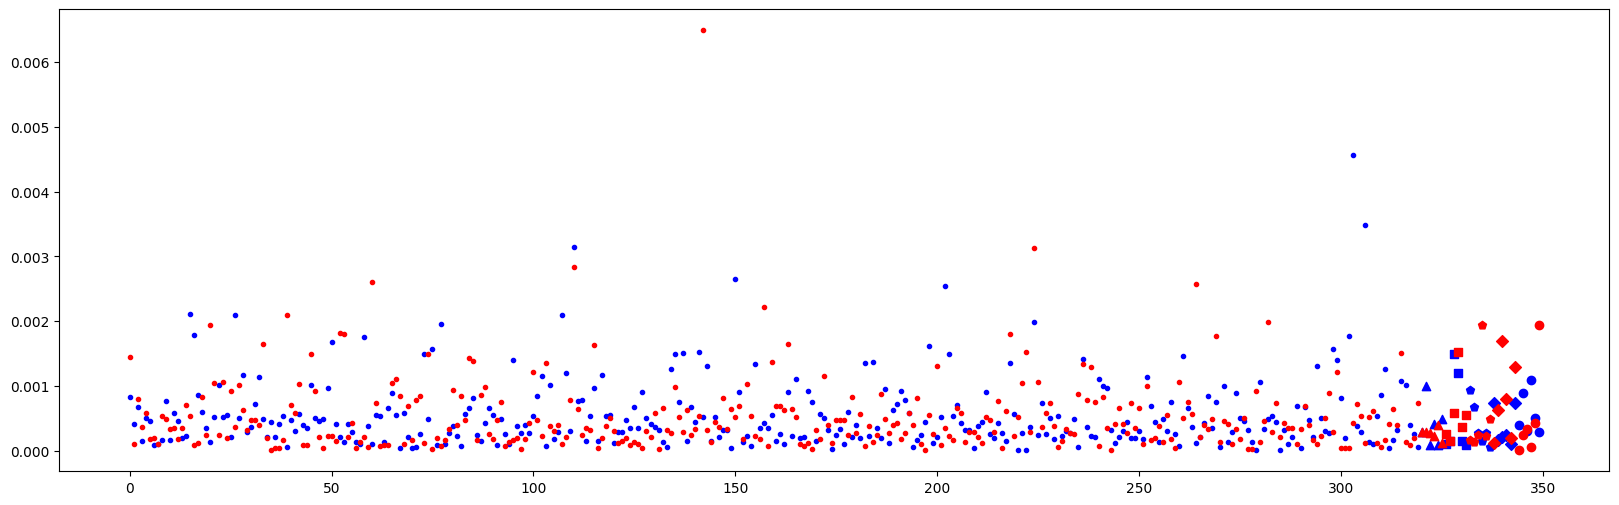

Text(0.5, 1.0, 'Difference between var scores outset-inset')

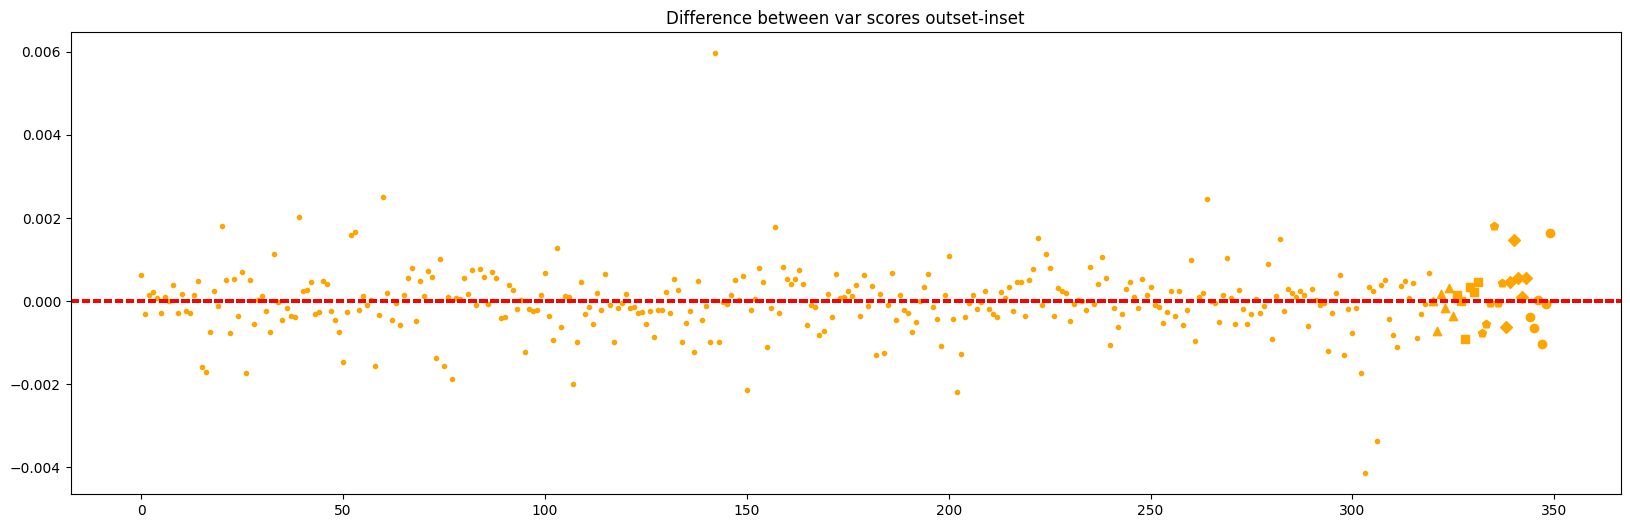

In [15]:
inset_tot_means={i:np.var(inset_tot[i]) for i in inset_tot.keys()}
outset_tot_means={i:np.var(outset_tot[i]) for i in outset_tot.keys()}

length=len(list(inset_tot_means.values()))
colors=['blue']*length
plt.figure(figsize=(20, 6))
for i in range(length):
    plt.scatter(list(np.arange(length))[i], list(inset_tot_means.values())[i],c=colors[i], marker=markers[i])
    
length=len(list(outset_tot_means.values()))
colors=['red']*length
    
for i in range(length):
    plt.scatter(list(np.arange(length))[i], list(outset_tot_means.values())[i],c=colors[i], marker=markers[i])
    
plt.show() 
    
plt.figure(figsize=(20, 6))
colors=['orange']*length

difference=np.array(list(outset_tot_means.values()))-np.array(list(inset_tot_means.values()))

for i in range(length):
    plt.scatter(list(np.arange(length))[i],difference[i],c=colors[i], marker=markers[i])
    plt.axhline(y=0, color='red', linestyle='--')
plt.title('Difference between var scores outset-inset')

## Furter scoring

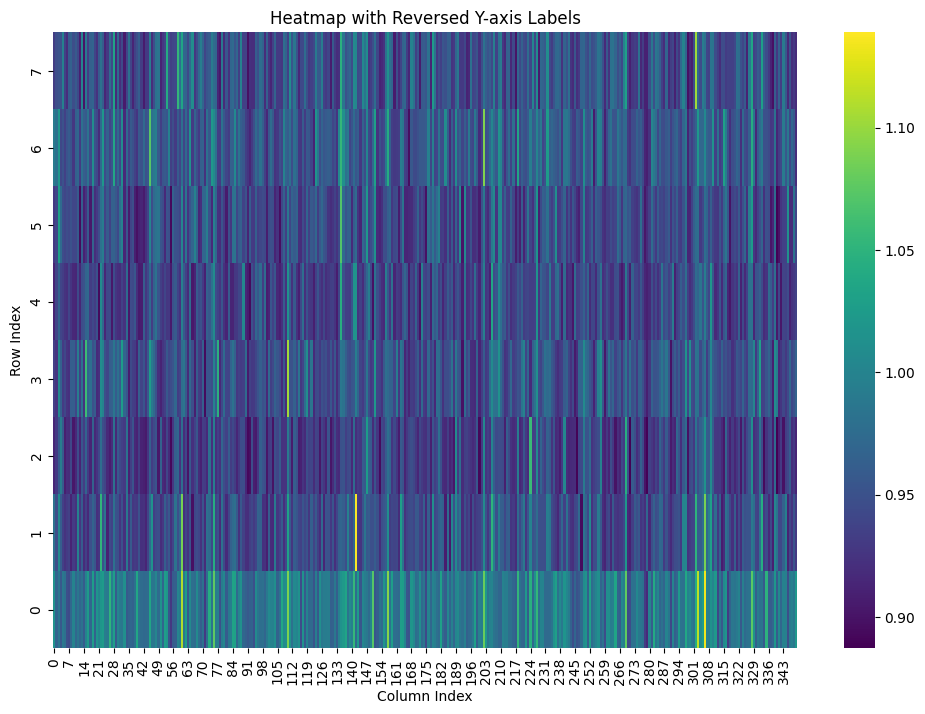

In [17]:
# min max scaling
scaled= (scores -scores.min())/ (scores.max()-scores.min())
# Create a heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(scores[::-1], cmap='viridis')

# Reverse the y-axis labels
ax.set_yticklabels(ax.get_yticklabels()[::-1])

plt.title('Heatmap with Reversed Y-axis Labels')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

In [18]:
np.random.seed(args.seed)
N_samples = len(train_data)
idx = np.arange(N_samples)
np.random.shuffle(idx)


stride = 35
window_size = 200
# Create train sets
shifts = np.floor(N_samples / stride)
train_sets = int(shifts)

train_ind_ls = []
for i in range(train_sets):
    train_ind_ls.append(idx[np.arange(i * stride, i * stride + window_size) % N_samples])
    
    
sorted_scores=[]
scaled_scores = (scores - scores.min()) / (scores.max() - scores.min())
for j in range(train_sets):
    sorted_part = [scaled_scores[j,i] for i in train_ind_ls[j]]
    remaining_part = [scaled_scores[j,i] for i in range(len(scaled_scores[j,:])) if i not in train_ind_ls[j]]
    sorted_scores.append(sorted_part + remaining_part)
    print(len(sorted_part),len(remaining_part),len(sorted_scores[j]))
sorted_scores = np.array(sorted_scores)

200 150 350
200 150 350
200 150 350
200 150 350
200 150 350
200 150 350
200 150 350
200 150 350


IndexError: index 8 is out of bounds for axis 0 with size 8

In [19]:
# Plotting the bar plot
inset=200

for i in range(sorted_scores.shape[0]):
    
    print(f'--------------------------------------------------------SET {i}--------------------------------------------------------')
    
    plt.figure(figsize=(10, 6))
    plt.hist(sorted_scores[i], color='blue', bins=100, alpha=0.7, label='allscores')
    plt.xlabel('Scores')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
    plt.figure(figsize=(10, 6))
    plt.hist(sorted_scores[i][:inset], color='blue', bins=100, alpha=0.7, label='inset')
    plt.hist(sorted_scores[i][inset:], color='red', bins=100, alpha=0.7, label='outset')
    plt.xlabel('Scores')
    plt.ylabel('Frequency')

    plt.title(f'USDR SCORE on contam set {args.contamination_rate}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
    
    plt.figure(figsize=(10, 5))
    colors = ['red' if x < inset else 'blue' for x in range(len(scaled[i]))]  # Color first 182 bars in red
    plt.bar(range(len(sorted_scores[i])), sorted_scores[i], color=colors)
    plt.xlabel('Items')
    plt.ylabel('Values')
    plt.title('Bar Plot of Data Array')
    #plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

AttributeError: 'list' object has no attribute 'shape'

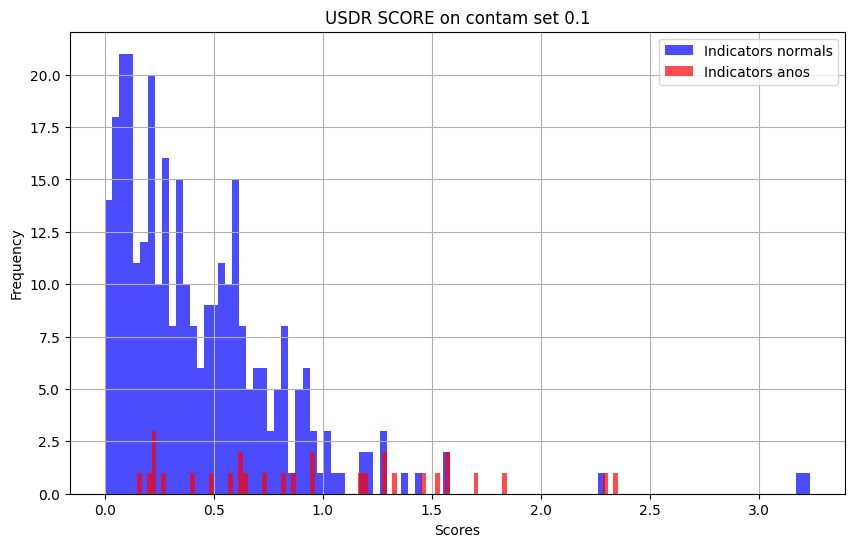

In [8]:
indicator=df['indicator']
idx=df['idx']
indicator=np.array(indicator)

idx_labs=[labels_train[idx] for idx in idx]
#indicator = np.abs(scores_test_mean - scores_train_mean)

score_0 = indicator[np.where(np.array(idx_labs) == 0)]
score_1 = indicator[np.where(np.array(idx_labs) == 1)]


plt.figure(figsize=(10, 6))
plt.hist(score_0, color='blue', bins=100, alpha=0.7, label='Indicators normals')
plt.hist(score_1, color='red', bins=100, alpha=0.7, label='Indicators anos')
plt.xlabel('Scores')
plt.ylabel('Frequency')

plt.title(f'USDR SCORE on contam set {args.contamination_rate}')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   indicator          350 non-null    float32
 1   idx                350 non-null    int64  
 2   scores_test_mean   350 non-null    float32
 3   scores_test_std    350 non-null    float32
 4   scores_train_mean  350 non-null    float32
 5   scores_train_std   350 non-null    float32
dtypes: float32(5), int64(1)
memory usage: 9.7 KB


In [ ]:
indicator=df['indicator']
idx=df['idx']

In [ ]:
path=os.path.join(EXPERIMENT_PATH,f'USDR_window:{window_size}_stride:{stride}.pkl')
resdict={'indicator':indicator,'idx':idx}
pd.DataFrame(resdict).to_pickle(os.path.join(EXPERIMENT_PATH,f'USDR_window:{window_size}_stride:{stride}.pkl'))

In [83]:

idx_labs=[labels_train[idx] for idx in idx]
indicator = np.abs(scores_test_mean - scores_train_mean)

score_0 = indicator[np.where(np.array(idx_labs) == 0)]
score_1 = indicator[np.where(np.array(idx_labs) == 1)]


plt.figure(figsize=(10, 6))
plt.hist(score_0, color='blue', bins=100, alpha=0.7, label='Indicators normals')
plt.hist(score_1, color='red', bins=100, alpha=0.7, label='Indicators anos')
plt.xlabel('Scores')
plt.ylabel('Frequency')

plt.title(f'USDR SCORE on contam set {args.contamination_rate}')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'scores_test_mean' is not defined

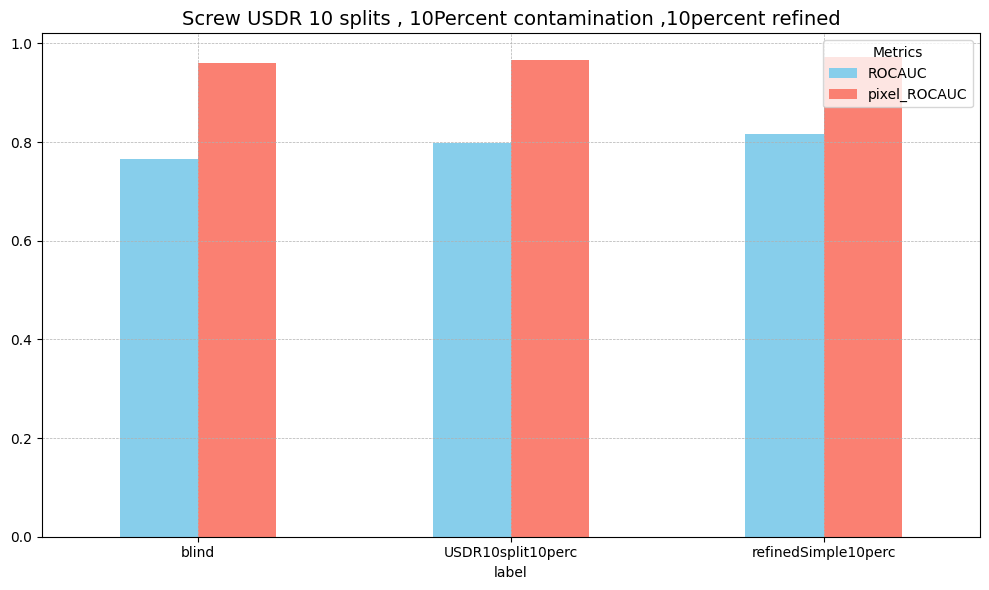

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the DataFrame
df = pd.DataFrame({'ROCAUC': [0.765, 0.799, 0.816], 'pixel_ROCAUC': [0.961, 0.966, 0.972],'label':['blind','USDR10split10perc','refinedSimple10perc']})

# Plotting
ax = df.plot(x='label', y=['ROCAUC', 'pixel_ROCAUC'], kind='bar', figsize=(10, 6), color=['skyblue', 'salmon'])

# Adding grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adding titles and labels
ax.set_title('Screw USDR 10 splits , 10Percent contamination ,10percent refined', fontsize=14)
ax.legend(title='Metrics')

# Display the plot
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Fewer data

In [95]:
import pickle
import numpy as np
import matplotlib.pyplot as plt


file_path = "/home/bule/projects/UTRAD/results/mvtec/contamination_10/DEV_FewData_24_05_24-screw/all_trainscores.pkl"
with open(file_path, "rb") as file:
    data = pickle.load(file)

file_path = "/home/bule/projects/UTRAD/results/mvtec/contamination_10/DEV_FewData_24_05_24-screw/all_testscores.pkl"
with open(file_path, "rb") as file:
    testscores = pickle.load(file)
    
import json
file_path = '/home/bule/projects/UTRAD/results/mvtec/contamination_10/DEV_FewData_24_05_24-screw/experiment_paths.json'

with open(file_path, 'r') as file:
    exppath = json.load(file)
    
paths=exppath['train']+exppath['leftout_train_paths']


score_0 = np.array(data.tolist()[:len(exppath['train'])])
score_0_S= (score_0 - min(score_0)) / (max(score_0) - min(score_0))
score_0_norm= (score_0 - np.mean(score_0)) / (np.sqrt(np.var(score_0)))-np.mean(score_0)


score_1 = np.array(data.tolist()[len(exppath['train']):])
score_1_S= (score_1 - min(score_1)) / (max(score_1) - min(score_1))
score_1_norm= (score_1 - np.mean(score_0)) / (np.sqrt(np.var(score_0)))-np.mean(score_1)

print(np.var(score_1_norm),np.var(score_0_norm))

anocount=[0 if 'good' in path else 1 for path in paths]
print(sum(anocount[:len(score_0)]),sum(anocount[len(score_1):]))

0.9353035278520526 0.9999999999999999
15 15


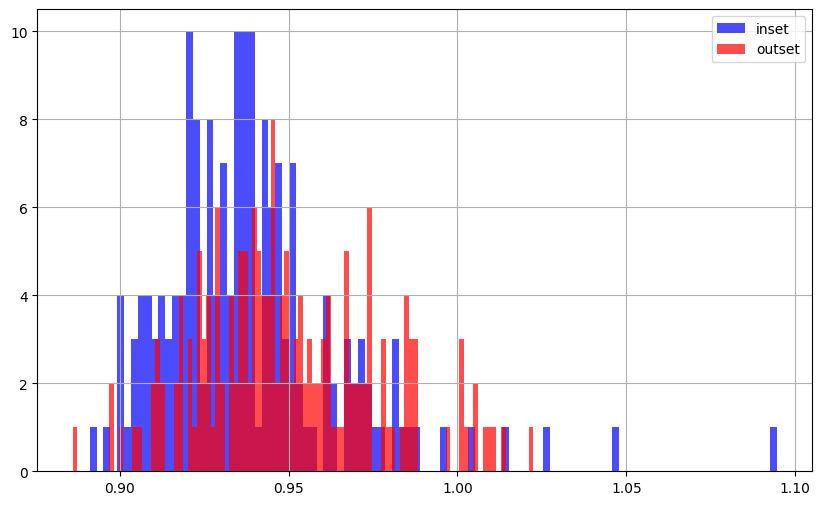

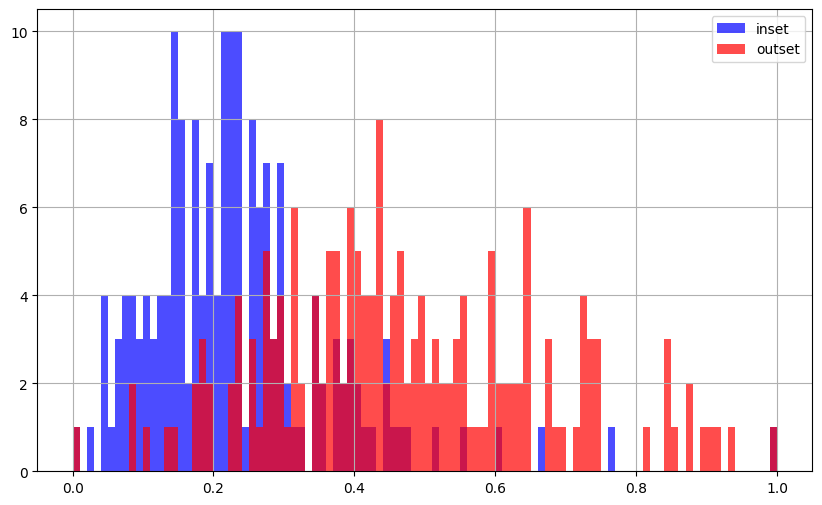

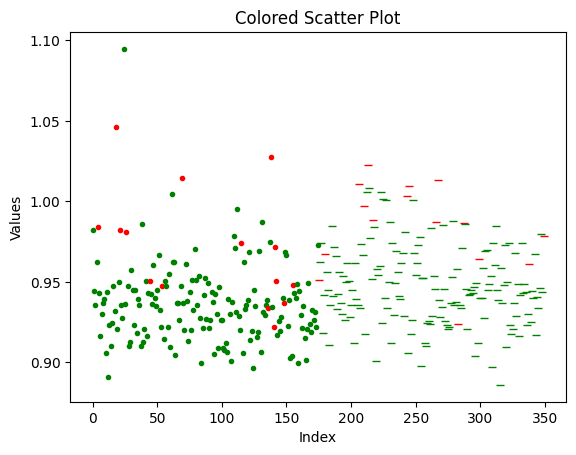

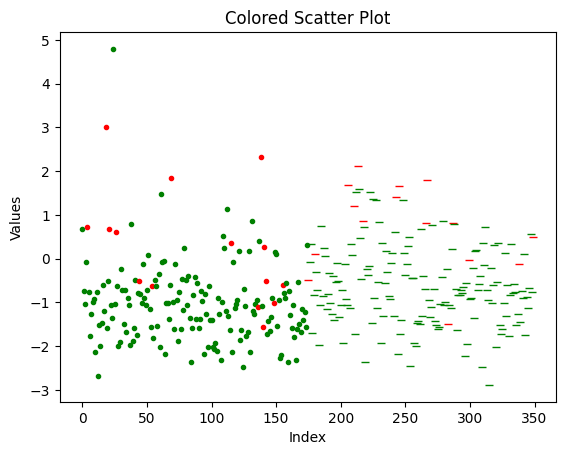

In [96]:
plt.figure(figsize=(10, 6))
plt.hist(score_0, color='blue', bins=100, alpha=0.7, label='inset')
plt.hist(score_1, color='red', bins=100, alpha=0.7, label='outset')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(score_0_S, color='blue', bins=100, alpha=0.7, label='inset')
plt.hist(score_1_S, color='red', bins=100, alpha=0.7, label='outset')
plt.legend()
plt.grid(True)
plt.show()
np.concatenate([score_0,score_1])



paths=exppath['train']+exppath['leftout_train_paths']
colors_ano=['green' if 'good' in path else 'red' for path in paths]
markers=['.']*len(score_0)+['_']*len(score_1)

# Plot each point with corresponding color
for i in range(len(np.concatenate([score_0,score_1]))):
    plt.plot(i, np.concatenate([score_0,score_1])[i], color=colors_ano[i],marker=markers[i])

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Colored Scatter Plot')
plt.show()


# Plot each point with corresponding color
for i in range(len(np.concatenate([score_0_norm,score_0_norm]))):
    plt.plot(i, np.concatenate([score_0_norm,score_1_norm])[i], color=colors_ano[i],marker=markers[i])

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Colored Scatter Plot')
plt.show()


In [97]:
allpaths=exppath['train']+exppath['leftout_train_paths']+exppath['test']

cats=['NA']*len(allpaths)
for cat in ['good']+anocat:
    cats=[cat if cat in path else cats[i] for i,path in enumerate(allpaths)]
    
df={'path':exppath['train']+exppath['leftout_train_paths']+exppath['test'],'scores':np.concatenate([score_0,score_1,testscores]),'set':['train']*len(score_0)+['infer']*len(score_1)+['test']*len(testscores),'anotype':cats}
df=pd.DataFrame(df)
set_order = {'train': 0, 'infer': 1, 'test': 2}
df['set_order'] = df['set'].map(set_order)
df = df.sort_values(by=['set_order', 'anotype'])
df.drop(columns=['set_order'])
df=df.reset_index(drop=True)
df

,path,scores,set,anotype,set_order
0,/home/bule/projects/datasets/mvtec_anomaly_det...,0.982522,train,good,0
1,/home/bule/projects/datasets/mvtec_anomaly_det...,0.944184,train,good,0
2,/home/bule/projects/datasets/mvtec_anomaly_det...,0.935839,train,good,0
3,/home/bule/projects/datasets/mvtec_anomaly_det...,0.962373,train,good,0
4,/home/bule/projects/datasets/mvtec_anomaly_det...,0.943342,train,good,0
...,...,...,...,...,...
475,/home/bule/projects/datasets/mvtec_anomaly_det...,1.083764,test,thread_top,2
476,/home/bule/projects/datasets/mvtec_anomaly_det...,1.064746,test,thread_top,2
477,/home/bule/projects/datasets/mvtec_anomaly_det...,1.001205,test,thread_top,2
478,/home/bule/projects/datasets/mvtec_anomaly_det...,0.973371,test,thread_top,2


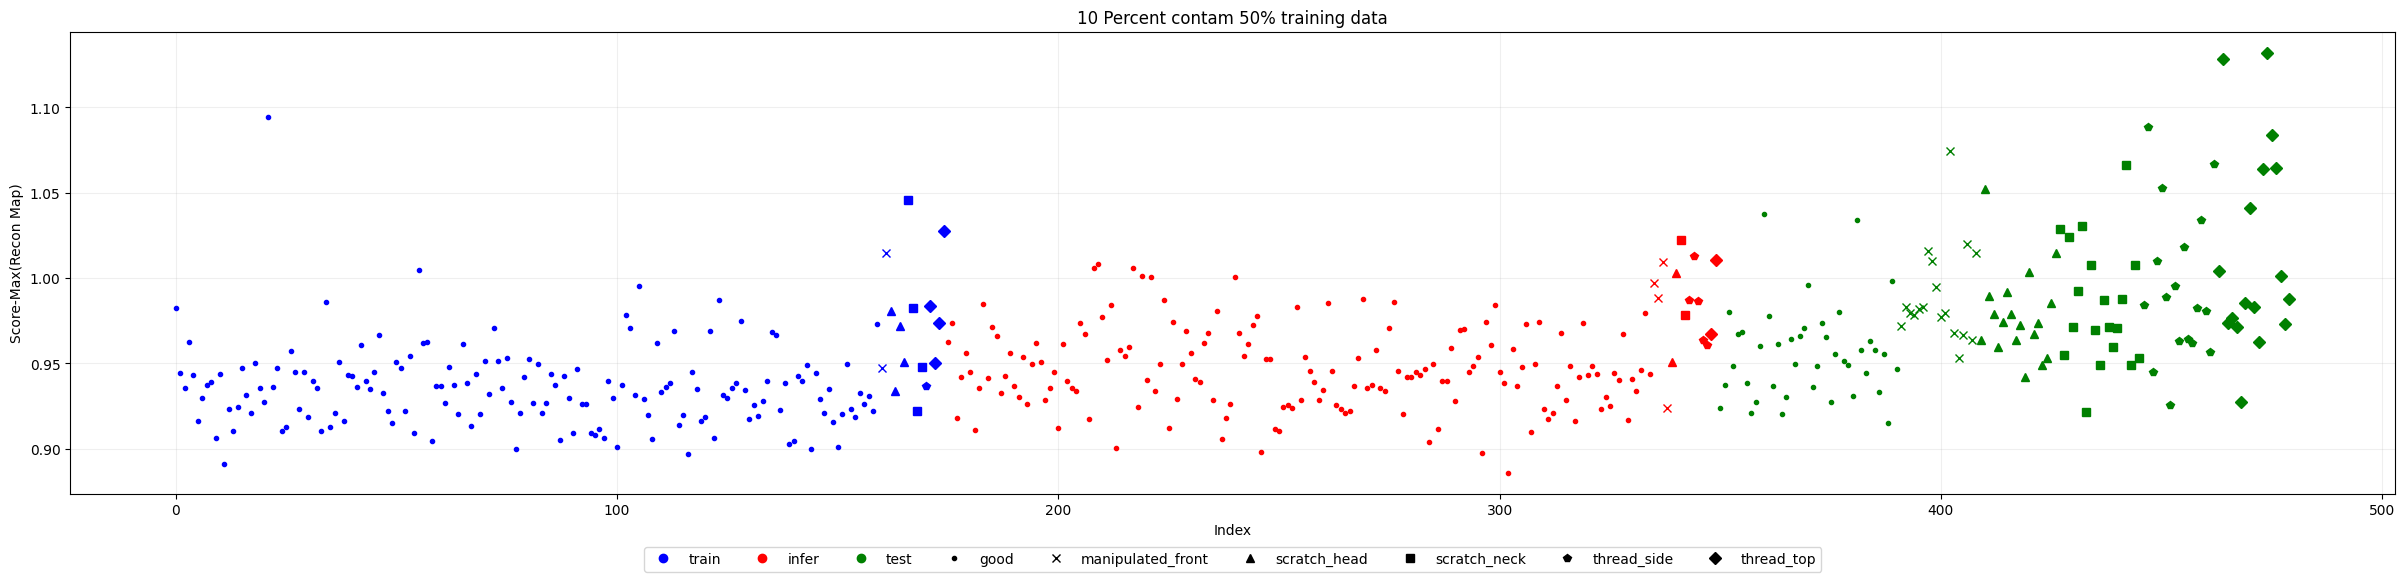

In [99]:
setcolors={'train':'blue','infer':'red','test':'green'}
anotype_marker={'good':'.','scratch':'_','manipulated_front':'x','scratch_head':'^','scratch_neck':'s','thread_side':'p','thread_top':'D'}

plt.figure(figsize=(30, 6))
plt.grid(alpha=0.2)

# Create dictionaries to hold labels for the legend
color_labels = {}
marker_labels = {}

for i in range(len(df)):
    set_label = df['set'][i]
    anotype_label = df['anotype'][i]
    plt.plot(i, df['scores'][i], color=setcolors[set_label], marker=anotype_marker[anotype_label])
    
    # Add to the color_labels dictionary if not already present
    if set_label not in color_labels:
        color_labels[set_label] = plt.Line2D([0], [0], color=setcolors[set_label], marker='o', linestyle='None')
    
    # Add to the marker_labels dictionary if not already present
    if anotype_label not in marker_labels:
        marker_labels[anotype_label] = plt.Line2D([0], [0], color='black', marker=anotype_marker[anotype_label], linestyle='None')

# Add the legends
plt.legend(handles=list(color_labels.values()) + list(marker_labels.values()),
           labels=list(color_labels.keys()) + list(marker_labels.keys()),
           loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(color_labels) + len(marker_labels))

plt.xlabel('Index')
plt.ylabel('Score-Max(Recon Map)')
plt.title('10 Percent contam 50% training data')
plt.show()



In [101]:
not False

True